# Part 5 - Object-oriented ML with PyTorch.

## Installation

In [1]:
import os
import subprocess

if not os.path.exists('.venv'):
  print('Creating a new virtual environment...')
  subprocess.run('python -m venv .venv')
  print('Done! Change your kernel to the new virtual environment before running subsequent cells.')
else:
  print('Virtual environment already exists. Change your kernel to it before running subsequent cells.')

Virtual environment already exists. Change your kernel to it before running subsequent cells.


Now make sure you've changed your kernel to the new virtual environment before running the next cells.

In [2]:
import subprocess

if not os.path.exists('.venv'):
  print('Installing required packages...')
  subprocess.run('pip install matplotlib scipy ipywidgets')
  # Install latest PyTorch for CUDA 11.8
  subprocess.run('pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118')
  print('Done!')
else:
  print('Virtual environment already exists. Skipping installation.')

Virtual environment already exists. Skipping installation.


## Initial setup again

In [3]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Open the raw dataset and display it

words = open('datasets/names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [5]:
# Display the length of words, its max, and its min

print(len(words))
print(min(len(w) for w in words))
print(max(len(w) for w in words))

32033
2
15


In [6]:
# Create an array of mappings to/from integers

strset = sorted(list(set(''.join(words))))
mapstrtoint = {s:(i + 1) for i, s in enumerate(strset)}
mapstrtoint['#'] = 0

mapinttostr = {i:s for s, i in mapstrtoint.items()}

vocab_size = len(mapinttostr)

print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 27


(-0.5, 26.5, 26.5, -0.5)

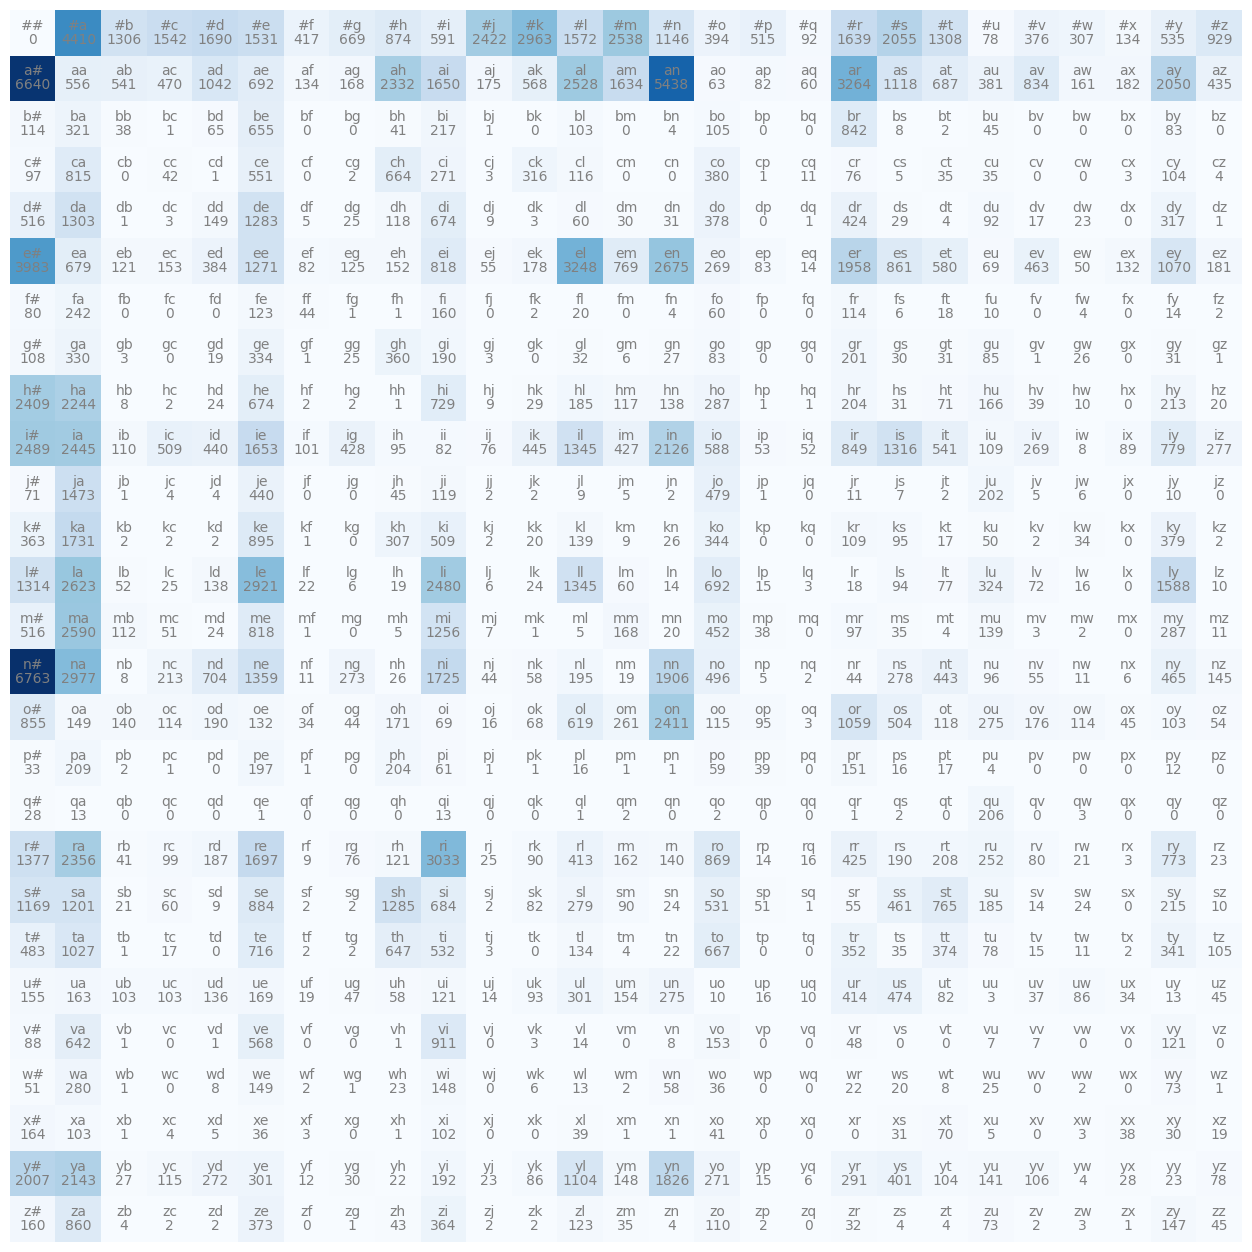

In [7]:
# Visualize the dataset

data = t.zeros((vocab_size, vocab_size), dtype=t.int32)

for w in words:
  chars = ['#'] + list(w) + ['#']
  for c1, c2 in zip(chars, chars[1:]):
    i1 = mapstrtoint[c1]
    i2 = mapstrtoint[c2]
    data[i1, i2] += 1

plt.figure(figsize=(16,16))
plt.imshow(data, cmap='Blues')
for i in range(vocab_size):
  for j in range(vocab_size):
    chstr = mapinttostr[i] + mapinttostr[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, data[i, j].item(), ha='center', va='top', color='gray')
    
plt.axis('off')

In [8]:
# Hyperparameters

input_block_size = 4
emb_dim = 10
num_layer_neurons = 200
learning_iterations = 180000
training_batch_size = 32

In [9]:
# Create a function to build a proper dataset

def build_dataset(words, block_size):
  mlp_inputs = []
  mlp_labels = []

  for w in words:
    context = [0] * block_size
    for c in w + '#':
      index = mapstrtoint[c]
      mlp_inputs.append(context)
      mlp_labels.append(index)
      context = context[1:] + [index]

  mlp_inputs = t.tensor(mlp_inputs).cuda()  # .cuda() to utilize the GPU
  mlp_labels = t.tensor(mlp_labels).cuda()
  print(mlp_inputs.shape, mlp_labels.shape)

  return mlp_inputs, mlp_labels

In [10]:
# Build and split the dataset

import random

random.seed()
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrn, Ytrn = build_dataset(words[:n1], input_block_size)
Xdev, Ydev = build_dataset(words[n1:n2], input_block_size)
Xtes, Ytes = build_dataset(words[n2:], input_block_size)

torch.Size([182735, 4]) torch.Size([182735])
torch.Size([22643, 4]) torch.Size([22643])
torch.Size([22768, 4]) torch.Size([22768])


### Model definition

In [11]:
# Create the neural network model with kaiming initialization and batch normalization

def reset_model():
  global lookup
  global weights_hidden
  global biases_hidden
  global weights_final
  global biases_final
  global mlp_params

  global batchnorm_weights
  global batchnorm_biases

  ####
  global batchnorm_running_mean
  global batchnorm_running_std
  ####
  
  lookup = t.randn((vocab_size, emb_dim))

  gain_tanh = 5 / 3

  std_hidden = gain_tanh / (input_block_size * emb_dim)**0.5
  weights_hidden = std_hidden * t.randn((input_block_size * emb_dim, num_layer_neurons))
  biases_hidden = 0.0 * t.randn(num_layer_neurons)

  gain_linear = 1

  std_final = gain_linear / num_layer_neurons**0.5
  weights_final =  std_final * t.randn((num_layer_neurons, vocab_size))
  biases_final = 0.0 * t.randn(vocab_size)

  batchnorm_weights = t.ones(1, num_layer_neurons)
  batchnorm_biases = t.zeros(1, num_layer_neurons)

  ####
  batchnorm_running_mean = t.zeros(1, num_layer_neurons)
  batchnorm_running_std = t.ones(1, num_layer_neurons)
  ####

  mlp_params = [lookup, weights_hidden, biases_hidden, weights_final, biases_hidden, batchnorm_weights, batchnorm_biases]

  for p in mlp_params:
    p.requires_grad = True

  print(f'Total number of parameters: {sum(p.nelement() for p in mlp_params)}')

### Training function

In [12]:
# Train the model and track the log-loss, now with batch norm

def train(iterations):
  # Track log-loss reduction
  log_loss_hist = []
  step_hist = []

  # Initial estimate of the optimal learning rate
  optimal_learning_rate = 0.1787

  for i in range(iterations):
    # Custom learning decay
    if 2 * i > iterations:
      # Stage 2
      optimal_learning_rate = 0.0790
    elif 3 * i > iterations:
      # Stage 1
      optimal_learning_rate = 0.1393

    # Increasing batch size reduces 'noise' when training
    batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))   

    # Forward pass
    emb = lookup[Xtrn[batch]]
    hidden = t.tanh(emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden)
    ####
    hidden_mean = hidden.mean(0, keepdim=True)
    hidden_std = hidden.std(0, keepdim=True)
    hidden = batchnorm_weights * (hidden - hidden_mean) / hidden_std + batchnorm_biases
    ####
    mlp_logits = hidden @ weights_final + biases_final

    ####
    with t.no_grad():
      global batchnorm_running_mean
      global batchnorm_running_std
      # Here, the momentum is 0.001. You want to set this lower the smaller the batch size to allow for convergence.
      batchnorm_running_mean = batchnorm_running_mean * 0.999 + hidden_mean * 0.001
      batchnorm_running_std = batchnorm_running_std * 0.999 + hidden_std * 0.001
    ####

    loss = F.cross_entropy(mlp_logits, Ytrn[batch])

    # Periodically print training loss
    if i % 10000 == 0:
      print(f'{i:7d} - {loss.item()}')

    # Backward pass
    for p in mlp_params:
      p.grad = None

    loss.backward()

    for p in mlp_params:
      p.data += -optimal_learning_rate * p.grad

    # Track the log-loss
    step_hist.append(i)
    log_loss_hist.append(loss.log10().item())

  return step_hist, log_loss_hist

### Evaluation function

In [13]:
# Create a function to view the loss in each set, now with batch normalization

@t.no_grad()
def display_loss():
  losses = []
  for X, Y in [(Xtrn, Ytrn), (Xdev, Ydev), (Xtes, Ytes)]:
    emb = lookup[X] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hidden = t.tanh(embcat @ weights_hidden + biases_hidden) # (N, n_hidden)
    hidden = batchnorm_weights * (hidden - batchnorm_running_mean) / batchnorm_running_std + batchnorm_biases
    logits = hidden @ weights_final + biases_final # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
  
  print(f'Training loss   = {losses[0]}')
  print(f'Validation loss = {losses[1]}')
  print(f'Testing loss    = {losses[2]}')

### Simple training pipeline

In [14]:
def plot_log_loss_hist(log_loss_hist, mean_window=1000):
  plt.plot(range(0, len(log_loss_hist), mean_window), t.tensor(log_loss_hist).view(-1, mean_window).mean(1))
  plt.xlabel('Steps')
  plt.ylabel('Log loss')
  plt.show()

def view_hidden_layer_distribution():
  batch = t.randint(0, Xtrn.shape[0], (training_batch_size,))
 
  emb = lookup[Xtrn[batch]]
  pre = emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden
  hidden = t.tanh(pre)

  plt.hist(pre.view(-1).tolist(), 100)
  plt.show()
  plt.hist(hidden.view(-1).tolist(), 100)
  plt.show()

def reset_train_eval():
  reset_model()
  print("Hidden layer weights distribution at initialization:")
  view_hidden_layer_distribution()
  steps, log_loss_hist = train(learning_iterations)
  print("Hidden layer weights distribution after training:")
  view_hidden_layer_distribution()
  display_loss()
  plot_log_loss_hist(log_loss_hist)

### Inference function

In [15]:
# Predict

def predict(seed=None):
  if seed != None:
    gen = t.Generator().manual_seed(seed)

  generated_names = []
  for i in range(30):
    context = [0] * input_block_size

    result = ''
    while True:
      # Get logits
      emb = lookup[t.tensor([context])]
      hidden = t.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ weights_hidden + biases_hidden)
      ####
      hidden = batchnorm_weights * (hidden - batchnorm_running_mean) / batchnorm_running_std + batchnorm_biases
      ####
      mlp_logits = hidden @ weights_final + biases_final

      # Exponentiate the logits and normalize them (sum to 1)
      probs = F.softmax(mlp_logits, dim=1)

      # Sample from probs to get the next character the neural network predicted
      sample_ind = t.multinomial(probs, num_samples=1, generator=gen).item()

      # End loop when the next sampled character is '#'
      if sample_ind == 0:
          break

      # Shift the context 'sliding window'
      context = context[1:] + [sample_ind]

      # Append result
      result += mapinttostr[sample_ind]

    generated_names += [result]

  print(generated_names)

## Object-oriented model building with PyTorch

In [16]:
# Check availability of devices

device = (
  'cuda' if t.cuda.is_available()
  else 'cpu'
)

print(f"Using {device}")

Using cuda


In [17]:
class Basic(nn.Module):
  
  def __init__(
    self,
    vocab_size,
    emb_dim,
    input_block_size,
    num_layer_neurons,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    
    self.lookup = nn.Embedding(vocab_size, emb_dim)
    # lookup = t.randn((vocab_size, emb_dim))

    self.flatten = nn.Flatten()
    # ...emb.view(emb.shape[0], -1)...

    self.hidden = nn.Linear(input_block_size * emb_dim, num_layer_neurons, bias=False)
    # gain_tanh = 5 / 3
    # std_hidden = gain_tanh / (input_block_size * emb_dim)**0.5
    # weights_hidden = std_hidden * t.randn((input_block_size * emb_dim, num_layer_neurons))
    # biases_hidden = 0.0 * t.randn(num_layer_neurons)

    self.batchnorm = nn.BatchNorm1d(num_layer_neurons)
    # batchnorm_weights = t.ones(1, num_layer_neurons)
    # batchnorm_biases = t.zeros(1, num_layer_neurons)
    # batchnorm_running_mean = t.zeros(1, num_layer_neurons)
    # batchnorm_running_std = t.ones(1, num_layer_neurons)

    self.tanh = nn.Tanh()
    # t.tanh(...)

    self.final = nn.Linear(num_layer_neurons, vocab_size)
    # gain_linear = 1
    # std_final = gain_linear / num_layer_neurons**0.5
    # weights_final =  std_final * t.randn((num_layer_neurons, vocab_size))
    # biases_final = 0.0 * t.randn(vocab_size)

  def forward(self, x):
    x = self.lookup(x)
    x = self.flatten(x)
    x = self.hidden(x)
    x = self.batchnorm(x)
    x = self.tanh(x)
    x = self.final(x)
    return x

In [18]:
# Instantiate model in device

model = Basic(vocab_size, emb_dim, input_block_size, num_layer_neurons)
model = model.to(device)

In [19]:
# Train the PyTorch model

def train(iterations):
  #### Set model to train mode
  model.train(True)
  ####

  # Track log-loss reduction
  log_loss_hist = []
  step_hist = []

  # Initial estimate of the optimal learning rate
  optimal_learning_rate = 0.1787

  for i in range(iterations):
    # Custom learning decay
    if 2 * i > iterations:
      # Stage 2
      optimal_learning_rate = 0.0790
    elif 3 * i > iterations:
      # Stage 1
      optimal_learning_rate = 0.1393

    # Increasing batch size reduces 'noise' when training
    batch = t.randint(0, Xtrn.shape[0], (training_batch_size,)).cuda()

    #### Forward pass
    mlp_logits = model(Xtrn[batch])
    # emb = lookup[Xtrn[batch]]
    # hidden = t.tanh(emb.view(emb.shape[0], -1) @ weights_hidden + biases_hidden)
    # hidden_mean = hidden.mean(0, keepdim=True)
    # hidden_std = hidden.std(0, keepdim=True)
    # hidden = batchnorm_weights * (hidden - hidden_mean) / hidden_std + batchnorm_biases
    # mlp_logits = hidden @ weights_final + biases_final
    # with t.no_grad():
    #   global batchnorm_running_mean
    #   global batchnorm_running_std
    #   # Here, the momentum is 0.001. You want to set this lower the smaller the batch size to allow for convergence.
    #   batchnorm_running_mean = batchnorm_running_mean * 0.999 + hidden_mean * 0.001
    #   batchnorm_running_std = batchnorm_running_std * 0.999 + hidden_std * 0.001
    ####

    loss = F.cross_entropy(mlp_logits, Ytrn[batch])

    # Periodically print training loss
    if i % 15000 == 0:
      print(f'Batch: {i:7d} - Loss: {loss.item()}')

    #### Backward pass
    for p in model.parameters():
      p.grad = None
    ####

    loss.backward()

    #### Update params
    for p in model.parameters():
      p.data += -optimal_learning_rate * p.grad
    ####

    # Track the log-loss
    step_hist.append(i)
    log_loss_hist.append(loss.log10().item())

  return step_hist, log_loss_hist

In [20]:
# Evaluate PyTorch model

@t.no_grad()
def display_loss():
  #### Set model to eval mode
  model.train(False)
  ####
  
  losses = []
  for X, Y in [(Xtrn, Ytrn), (Xdev, Ydev), (Xtes, Ytes)]:
    ####
    logits = model(X)
    # emb = lookup[X] # (N, block_size, n_embd)
    # embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # hidden = t.tanh(embcat @ weights_hidden + biases_hidden) # (N, n_hidden)
    # hidden = batchnorm_weights * (hidden - batchnorm_running_mean) / batchnorm_running_std + batchnorm_biases
    # logits = hidden @ weights_final + biases_final # (N, vocab_size)
    ####
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
  
  print(f'Training loss   = {losses[0]}')
  print(f'Validation loss = {losses[1]}')
  print(f'Testing loss    = {losses[2]}')

In [26]:
# Predict from PyTorch model

def predict(seed=None):
  #### Set model to eval mode
  model.train(False)
  ####

  if seed != None:
    gen = t.Generator(device='cuda').manual_seed(seed)

  generated_names = []
  for i in range(30):
    context = [0] * input_block_size

    result = ''
    while True:
      #### Get logits
      mlp_logits = model(t.tensor([context]).cuda())
      # emb = lookup[t.tensor([context])]
      # hidden = t.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ weights_hidden + biases_hidden)
      # hidden = batchnorm_weights * (hidden - batchnorm_running_mean) / batchnorm_running_std + batchnorm_biases
      # mlp_logits = hidden @ weights_final + biases_final
      ####

      # Exponentiate the logits and normalize them (sum to 1)
      probs = F.softmax(mlp_logits, dim=1)

      # Sample from probs to get the next character the neural network predicted
      sample_ind = t.multinomial(probs, num_samples=1, generator=gen).item()

      # End loop when the next sampled character is '#'
      if sample_ind == 0:
          break

      # Shift the context 'sliding window'
      context = context[1:] + [sample_ind]

      # Append result
      result += mapinttostr[sample_ind]

    generated_names += [result]

  print(generated_names)

In [22]:
def plot_log_loss_hist(log_loss_hist, mean_window=1000):
  plt.plot(range(0, len(log_loss_hist), mean_window), t.tensor(log_loss_hist).view(-1, mean_window).mean(1))
  plt.xlabel('Steps')
  plt.ylabel('Log loss')
  plt.show()

def reset_train_eval():
  _, log_loss_hist = train(learning_iterations)
  display_loss()
  plot_log_loss_hist(log_loss_hist)

Batch:       0 - Loss: 3.2859325408935547
Batch:   15000 - Loss: 1.9963340759277344
Batch:   30000 - Loss: 2.095263957977295
Batch:   45000 - Loss: 1.9970619678497314
Batch:   60000 - Loss: 2.1145598888397217
Batch:   75000 - Loss: 2.445784091949463
Batch:   90000 - Loss: 2.7850582599639893
Batch:  105000 - Loss: 1.9521398544311523
Batch:  120000 - Loss: 2.095621347427368
Batch:  135000 - Loss: 2.0784714221954346
Batch:  150000 - Loss: 1.9363821744918823
Batch:  165000 - Loss: 2.1899077892303467
Training loss   = 2.0517075061798096
Validation loss = 2.1223902702331543
Testing loss    = 2.1141462326049805


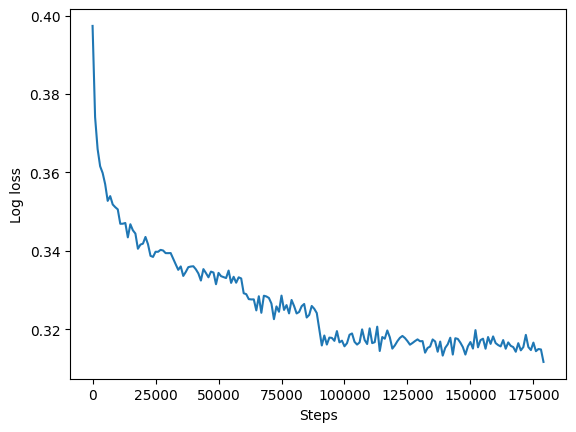

In [23]:
reset_train_eval()

In [27]:
predict(69)

['javontae', 'mate', 'olaja', 'makkiya', 'mila', 'econ', 'kajie', 'aken', 'kend', 'abell', 'yameyza', 'nika', 'kadis', 'meylynn', 'alara', 'aubeth', 'dishacsyn', 'charna', 'hidangensiya', 'leila', 'makamor', 'aspuyn', 'tremylae', 'keoni', 'xadrekdo', 'haydon', 'kentlysenrah', 'koralynn', 'daya', 'jeamatalykadisa']


## Example: "WaveNet" structure implementation

In [95]:
class GroupEmbedding(nn.Module):
  def __init__(self, factor: int = 2):
    super().__init__()
    self.factor = factor

  def forward(self, input: t.Tensor):
    shape = input.shape
    input = input.view(shape[0], -1, shape[-1] * self.factor)
    return input if input.shape[-2] != 1 else input.squeeze(-2)

  def extra_repr(self) -> str:
    return f'factor={self.factor}'

class WaveNet(nn.Module):
  
  def __init__(
    self,
    vocab_size,
    emb_dim,
    input_block_size,
    group_size,
    num_layer_neurons,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    
    self.lookup = nn.Embedding(vocab_size, emb_dim)

    input_block_size //= group_size
    self.block_0 = nn.Sequential(
      GroupEmbedding(group_size),
      nn.Linear(group_size * emb_dim, num_layer_neurons, bias=False),
      nn.BatchNorm1d(input_block_size),
      nn.Tanh(),
    )

    input_block_size //= group_size
    self.block_1 = nn.Sequential(
      GroupEmbedding(group_size),
      nn.Linear(group_size * num_layer_neurons, num_layer_neurons, bias=False),
      nn.BatchNorm1d(input_block_size),
      nn.Tanh(),
    )

    self.last_block = nn.Sequential(
      GroupEmbedding(group_size),
      nn.Linear(group_size * num_layer_neurons, num_layer_neurons, bias=False),
      nn.BatchNorm1d(num_layer_neurons),
      nn.Tanh(),
    )

    self.final = nn.Linear(num_layer_neurons, vocab_size)

  def forward(self, x):
    x = self.lookup(x)
    x = self.block_0(x)
    x = self.block_1(x)
    x = self.last_block(x)
    x = self.final(x)
    return x

In [70]:
# Increase block size

input_block_size = 8

In [71]:
# Rebuild dataset

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrn, Ytrn = build_dataset(words[:n1], input_block_size)
Xdev, Ydev = build_dataset(words[n1:n2], input_block_size)
Xtes, Ytes = build_dataset(words[n2:], input_block_size)

torch.Size([182427, 8]) torch.Size([182427])
torch.Size([22852, 8]) torch.Size([22852])
torch.Size([22867, 8]) torch.Size([22867])


In [34]:
basic_model = model

In [96]:
# Instantiate model in device

group_size = 2  # (cubic root of 8)

model = WaveNet(vocab_size, emb_dim, input_block_size, group_size, num_layer_neurons)
model = model.to(device)

In [97]:
model

WaveNet(
  (lookup): Embedding(27, 10)
  (block_0): Sequential(
    (0): GroupEmbedding(factor=2)
    (1): Linear(in_features=20, out_features=200, bias=False)
    (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
  )
  (block_1): Sequential(
    (0): GroupEmbedding(factor=2)
    (1): Linear(in_features=400, out_features=200, bias=False)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
  )
  (last_block): Sequential(
    (0): GroupEmbedding(factor=2)
    (1): Linear(in_features=400, out_features=200, bias=False)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
  )
  (final): Linear(in_features=200, out_features=27, bias=True)
)

Batch:       0 - Loss: 3.3560593128204346
Batch:   15000 - Loss: 2.094456434249878
Batch:   30000 - Loss: 2.287414073944092
Batch:   45000 - Loss: 2.157564163208008
Batch:   60000 - Loss: 2.0257408618927
Batch:   75000 - Loss: 1.7671853303909302
Batch:   90000 - Loss: 1.6970891952514648
Batch:  105000 - Loss: 1.9333022832870483
Batch:  120000 - Loss: 1.8882107734680176
Batch:  135000 - Loss: 2.167881727218628
Batch:  150000 - Loss: 2.1600329875946045
Batch:  165000 - Loss: 1.7912647724151611
Training loss   = 1.7794862985610962
Validation loss = 2.0236449241638184
Testing loss    = 2.0272936820983887


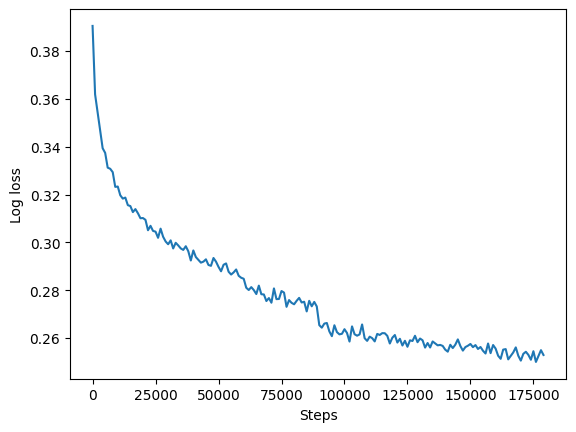

In [98]:
reset_train_eval()

In [99]:
predict(69)

['janella', 'milee', 'oluwamaria', 'tannleigh', 'brandon', 'aakin', 'renity', 'jenoni', 'eyzlene', 'avonni', 'khyree', 'kealani', 'aubitha', 'nivellah', 'cecen', 'ahmir', 'gabeth', 'kimiah', 'lauron', 'jaspen', 'zurimylazi', 'ezekiel', 'regdan', 'jaron', 'keanna', 'anabee', 'neffaan', 'rhyle', 'laurianna', 'desankida']
